In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from copy import copy, deepcopy

In [2]:
import tensorflow_datasets as tfds

data = tfds.load("cifar10")
train, test = data["train"], data["test"]

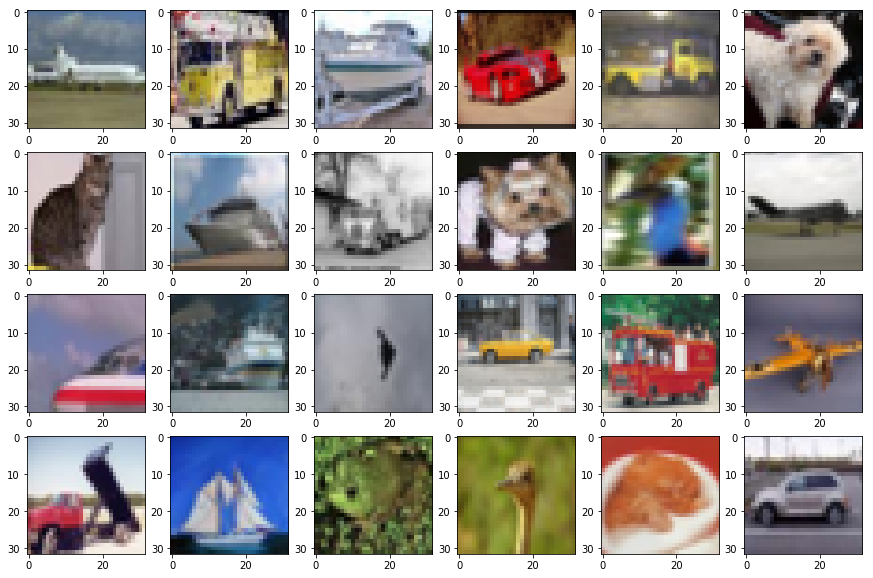

In [3]:
# 24 random images from cifar10
list_images = [data["image"] for data in train.shuffle(20000).take(4 * 6)]

plt.figure(figsize=(15, 10))
for index, image in enumerate(list_images):
    plt.subplot(4, 6, index + 1)
    plt.imshow(image)

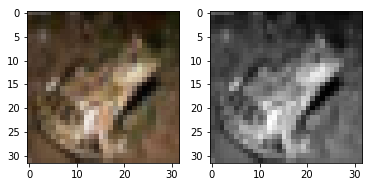

In [4]:
from skimage import color
plt.subplot()
plt.subplot(1, 2, 1)
data = [data for data in train.shuffle(1000).take(1)][0]
image = data["image"]
plt.imshow(image)

plt.subplot(1, 2, 2)
lab_image = color.rgb2lab(image)
plt.imshow((lab_image[:, :, 0]), cmap="gray")

In [5]:
a_values = []
b_values = []
l_values = []
for feature in tqdm(train.shuffle(1000000).take(10000), total=10000):
    lab_image = color.rgb2lab(feature["image"])
    l_values.append(lab_image[:, :, 0])
    a_values.append(lab_image[:, :, 1])
    b_values.append(lab_image[:, :, 2])

l_values = np.array(l_values).flatten()
a_values = np.array(a_values).flatten()
b_values = np.array(b_values).flatten()

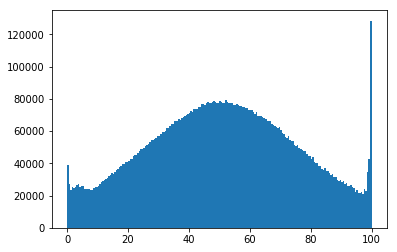

In [6]:
plt.hist(l_values, bins=200)
None

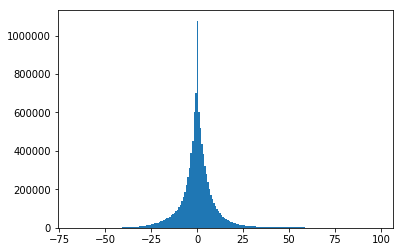

In [7]:
plt.hist(a_values, bins=200)
None

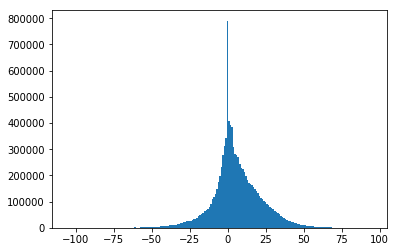

In [8]:
plt.hist(b_values, bins=200)
None

In [5]:
BINS_CUTS = [-100, -50, -25, -15, -10, -5, 0, 5, 10, 15, 25, 50, 100]
n_bins = len(BINS_CUTS) + 1

In [22]:
def bin_value(bins, value):
    cut_0 = bins[0]
    for index, cut in enumerate(bins[1:]):
        if cut_0 <= value < cut:
            return index
        cut_0 = cut
        
    return index

def unbin_value(bins, value):
    return bins[value]

def pre_process(cifar10_data):
    image = cifar10_data["image"]
    rgb_image = np.array(image)
    lab_image = color.rgb2lab(rgb_image)
    
    # get features (i.e. the luminance)
    features = lab_image[:, :, 0:1]
    
    # get labels (i.e the ab channels)
    raw_a, raw_b = lab_image[:, :, 1:2], lab_image[:, :, 2:3]
    v_bin_value = np.vectorize(lambda value: bin_value(BINS_CUTS, value))
    bins_a = v_bin_value(raw_a)
    bins_b = v_bin_value(raw_b)
    labels = (bins_a, bins_b)
    
    return features, labels

def process_output(input_luminance, output_bins):
    bins_a, bins_b = output_bins
    v_unbin_value = np.vectorize(lambda value: unbin_value(BINS_CUTS, value))
    unbins_a = v_unbin_value(bins_a)
    unbins_b = v_unbin_value(bins_b)
    reconstructed_image = np.stack((input_luminance, unbins_a, unbins_b), axis=2)
    rgb_rec_image = color.lab2rgb(reconstructed_image)
    return rgb_rec_image

data = [data for data in train.shuffle(1000).take(1)][0]
new_feature, new_label = pre_process(data)

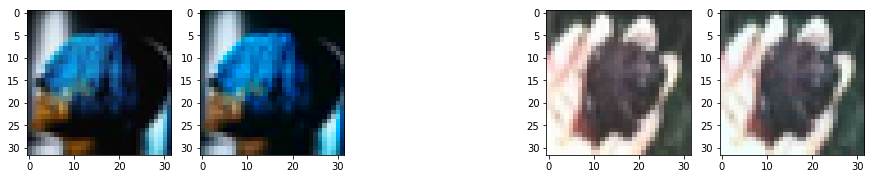

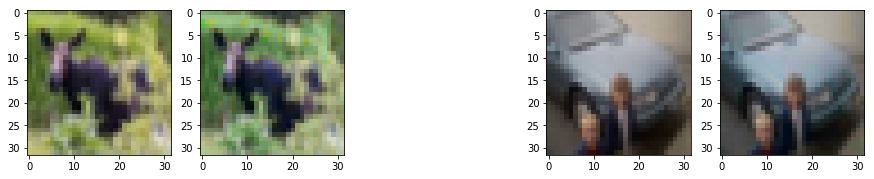

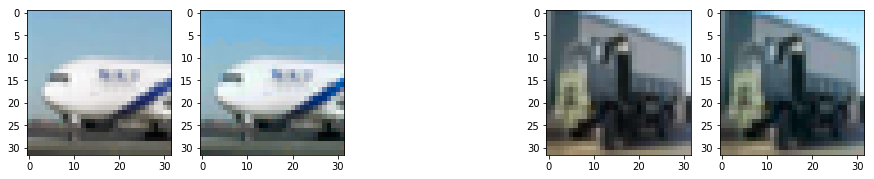

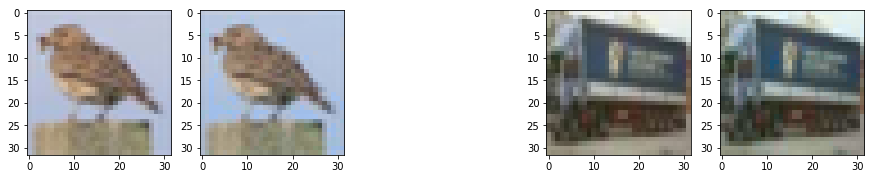

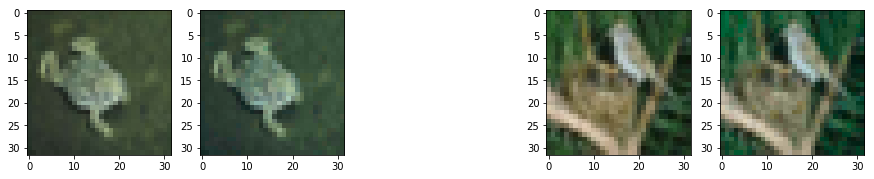

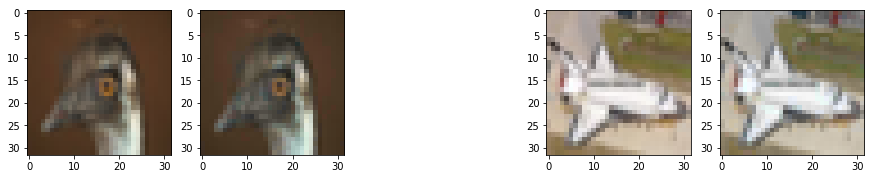

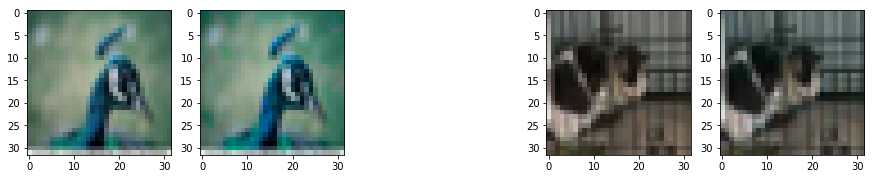

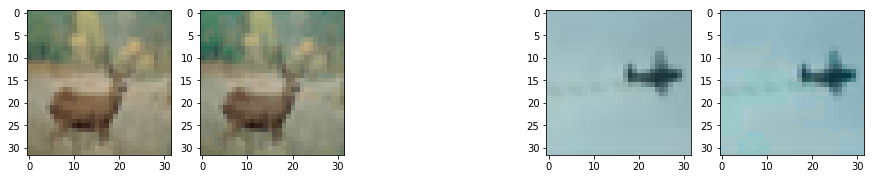

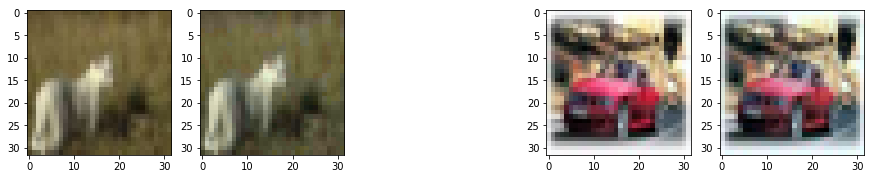

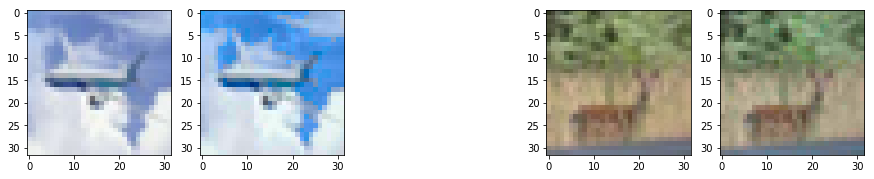

In [11]:
for index, data in enumerate(train.shuffle(10000).take(20)):
    if index % 2 == 0:
        plt.figure(figsize=(15, 5))
        base_index = 1
    else:
        base_index = 4
        
    plt.subplot(1, 5, base_index)
    plt.imshow(data["image"])
    
    new_feature, new_label = pre_process(data)
    reconstructed_image = process_output(new_feature, new_label)
    plt.subplot(1, 5, base_index + 1)
    plt.imshow(reconstructed_image)

In [85]:
numpy_train = tfds.as_numpy(train)
def get_dataset():
    def aux_generator():
        numpy_train = tfds.as_numpy(train)
        for data in numpy_train:
            yield pre_process(data)
    
    data = tf.data.Dataset.from_generator(aux_generator,
                                          output_types=(np.float32, np.int64))
    data = data.shuffle(60000).batch(32)
    return data

dataset = get_dataset()

In [262]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        # (batch_size, 32, 32, 1) --> (batch_size, 16, 16, 8)
        self.conv1 = tf.keras.layers.Conv2D(filters=8, kernel_size=5,
                                            strides=(2, 2),
                                            padding='same',
                                            activation='relu',
                                            input_shape=(32, 32, 1))
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        # (batch_size, 16, 16, 8) --> (batch_size, 8, 8, 16)
        self.conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3,
                                            strides=(2, 2),
                                            padding='same',
                                            activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()

        
        # (batch_size, 8, 8, 16)  --> (batch_size, 4, 4, 32)
        self.conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                            strides=(2, 2),
                                            padding='same',
                                            activation='relu')
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        # (batch_size, 4, 4, 32) --> (batch_size, 4, 4, 64)
        self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                            strides=(1, 1),
                                            padding='same',
                                            activation='relu')
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        # (batch_size, 4, 4, 64) --> (batch_size, 8, 8, 32)
        self.deconv1 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,
                                                       strides=(2, 2),
                                                       padding='same',
                                                       activation='relu')
        self.bn5 = tf.keras.layers.BatchNormalization()
        
        # (batch_size, 8, 8, 32) --> (batch_size, 16, 16, 32)
        self.deconv2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,
                                                       strides=(2, 2),
                                                       padding='same',
                                                       activation='relu')
        self.bn6 = tf.keras.layers.BatchNormalization()
        
        # (batch_size, 16, 16, 32) --> (batch_size, 32, 32, 32)
        self.deconv3 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,
                                                       strides=(2, 2),
                                                       padding='same',
                                                       activation='relu')
        self.bn7 = tf.keras.layers.BatchNormalization()
        
        # (batch_size, 32, 32, 32) --> (batch_size, 32, 32, n_bins)
        self.deconv_a = tf.keras.layers.Conv2DTranspose(filters=n_bins, kernel_size=1,
                                                        activation='softmax',
                                                        strides=(1, 1))
        self.deconv_b = tf.keras.layers.Conv2DTranspose(filters=n_bins, kernel_size=1,
                                                        activation='softmax',
                                                        strides=(1, 1))
        
        self.seq_layers = [self.conv1, self.bn1,
                           self.conv2, self.bn2,
                           self.conv3, self.bn3,
                           self.conv4, self.bn4,
                           self.deconv1, self.bn5,
                           self.deconv2, self.bn6,
                           self.deconv3, self.bn7]
        
    def call(self, inputs):
        x = inputs
        for layer in self.seq_layers:
            x = layer(x)
        probs_a = self.deconv_a(x)
        probs_b = self.deconv_b(x)
        return probs_a, probs_b
        
model = Model()

In [263]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_a = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_a')
train_accuracy_b = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_b')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy_a = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy_a')
test_accuracy_b = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy_b')
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(image, labels_a, labels_b):
    with tf.GradientTape() as tape:
        probs_a, probs_b = model(image)
        loss_a = loss_object(labels_a, probs_a)
        loss_b = loss_object(labels_b, probs_b)
        loss = loss_a + loss_b
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy_a(labels_a, probs_a)
    train_accuracy_b(labels_b, probs_b)
    
@tf.function
def test_step(image, labels_a, labels_b):
    probs_a, probs_b = model(image)
    t_loss_a = loss_object(labels_a, probs_a)
    t_loss_b = loss_object(labels_b, probs_b)
    t_loss = t_loss_a + t_loss_b

    test_loss(t_loss)
    test_accuracy_a(labels_a, probs_a)
    test_accuracy_b(labels_b, probs_b)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for index, (batch_luminance, batch_ab) in tqdm(enumerate(get_dataset()), total=60000//32):
        train_step(batch_luminance, batch_ab[:, 0, :, : , :], batch_ab[:, 1, :, : , :])
        if index % 100 == 0:
            template = 'Epoch {}, Step {}, Loss: {}, Accuracy a: {}, Accuracy b: {}'
            print(template.format(epoch+1,
                                  index,
                                  round(float(train_loss.result()), 3),
                                  round(float(train_accuracy_a.result()) * 100, 2),
                                  round(float(train_accuracy_b.result()) * 100, 2)))

    template = 'Epoch {}, Loss: {}, Accuracy a: {}, Accuracy b: {}'
    print(template.format(epoch + 1,
                          round(float(train_loss.result()), 3),
                          round(float(train_accuracy_a.result()) * 100, 2),
                          round(float(train_accuracy_b.result()) * 100, 2)))
        


Epoch 1, Step 0, Loss: 5.301, Accuracy a: 6.42, Accuracy b: 5.65
Epoch 1, Step 100, Loss: 4.293, Accuracy a: 28.41, Accuracy b: 20.35
Epoch 1, Step 200, Loss: 4.183, Accuracy a: 29.56, Accuracy b: 20.37
Epoch 1, Step 300, Loss: 4.13, Accuracy a: 30.22, Accuracy b: 20.59
Epoch 1, Step 400, Loss: 4.099, Accuracy a: 30.67, Accuracy b: 20.72
Epoch 1, Step 500, Loss: 4.078, Accuracy a: 30.87, Accuracy b: 20.84
Epoch 1, Step 600, Loss: 4.062, Accuracy a: 31.03, Accuracy b: 20.93
Epoch 1, Step 700, Loss: 4.049, Accuracy a: 31.13, Accuracy b: 21.16
Epoch 1, Step 800, Loss: 4.038, Accuracy a: 31.23, Accuracy b: 21.29
Epoch 1, Step 900, Loss: 4.028, Accuracy a: 31.38, Accuracy b: 21.45
Epoch 1, Step 1000, Loss: 4.019, Accuracy a: 31.41, Accuracy b: 21.57
Epoch 1, Step 1100, Loss: 4.011, Accuracy a: 31.53, Accuracy b: 21.64
Epoch 1, Step 1200, Loss: 4.004, Accuracy a: 31.57, Accuracy b: 21.73
Epoch 1, Step 1300, Loss: 3.999, Accuracy a: 31.68, Accuracy b: 21.82
Epoch 1, Step 1400, Loss: 3.992, Ac

Epoch 2, Step 0, Loss: 3.982, Accuracy a: 31.88, Accuracy b: 22.06
Epoch 2, Step 100, Loss: 3.978, Accuracy a: 31.93, Accuracy b: 22.14
Epoch 2, Step 200, Loss: 3.973, Accuracy a: 31.99, Accuracy b: 22.19
Epoch 2, Step 300, Loss: 3.968, Accuracy a: 32.02, Accuracy b: 22.27


In [95]:
p_image

(array([[[68.40466899],
         [71.3742898 ],
         [73.94097187],
         ...,
         [72.33007806],
         [74.61156023],
         [68.3898002 ]],
 
        [[66.29399019],
         [69.22490932],
         [71.81904978],
         ...,
         [65.17517936],
         [68.60453334],
         [62.99535196]],
 
        [[63.5049458 ],
         [67.07819752],
         [72.06736576],
         ...,
         [70.93617962],
         [68.43806977],
         [75.48985878]],
 
        ...,
 
        [[50.75758572],
         [46.1075272 ],
         [53.76550108],
         ...,
         [78.92979737],
         [75.96254536],
         [67.98331297]],
 
        [[52.94681278],
         [55.08193191],
         [61.17733524],
         ...,
         [79.5809672 ],
         [76.94465052],
         [77.34209166]],
 
        [[58.11568925],
         [62.45745217],
         [65.9253005 ],
         ...,
         [74.06094672],
         [75.5035503 ],
         [73.46587244]]]), (array([[[5],
     

In [ ]:
images = [data for data in test.shuffle(2000)]

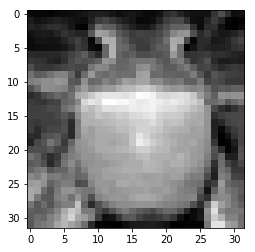

In [257]:
image = images[np.random.randint(0, 2000)]
feature, labels = pre_process(image)
plt.imshow(feature[:, :, 0], cmap="gray")

In [144]:
@tf.function
def test_step(image, labels_a, labels_b):
    probs_a, probs_b = model(image)
    t_loss_a = loss_object(labels_a, probs_a)
    t_loss_b = loss_object(labels_b, probs_b)
    t_loss = t_loss_a + t_loss_b

    test_loss(t_loss)
    test_accuracy_a(labels_a, probs_a)
    test_accuracy_b(labels_b, probs_b)

In [160]:
test_step(np.array([feature], np.float32),
          np.array([labels[0]], np.float32),
          np.array([labels[1]], np.float32))



In [258]:
probs_a, probs_b = model(np.array([feature], np.float32))

In [259]:
a = tf.argmax(probs_a[0], axis=-1)
b = tf.argmax(probs_b[0], axis=-1)

In [260]:
final_image = process_output(feature[:, :, 0], (a, b))

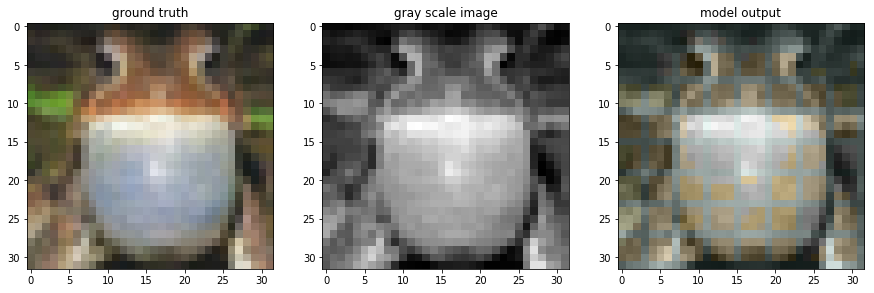

In [261]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(np.array(image["image"]))
plt.title("ground truth")

plt.subplot(1, 3, 2)
plt.imshow(feature[:, :, 0], cmap="gray")
plt.title("gray scale image")

plt.subplot(1, 3, 3)
plt.imshow(final_image)
plt.title("model output")

plt.savefig("C:/Users/louis/Documents/3A_berkeley/spring_semester/242/PROJECT/early_results/{}".format(save_index))
save_index += 1

In [237]:
save_index -= 1